<a href="https://colab.research.google.com/github/briannabinder/AME508_finalproject/blob/main/112723AME508.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import requests
import base64
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal
from scipy.io import wavfile
from torchsummary import summary
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsampler import ImbalancedDatasetSampler


Drive mount from my personal driver

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Wav to spectrogram

File: trunc_2019-05-31-14-07-30-L4_0.wav, Frequency: 0.0 Hz, Time: 0.032 sec


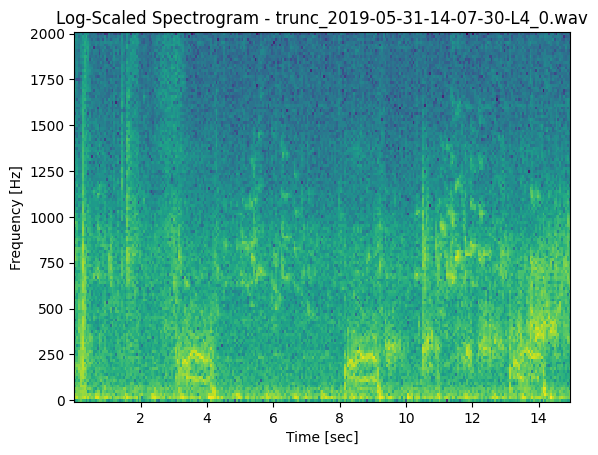

In [3]:
# Specify the folder path
#folder_path = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Train_Datasets'
folder_path = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/train'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.wav')]



# List to store all log_spectrograms
all_spectrograms = []

# Iterate through each .wav file in the folder
for wav_file in file_list:
    # Construct the full path to the .wav file
    wav_file_path = os.path.join(folder_path, wav_file)

    # Read the content of the .wav file
    sample_rate, samples = wavfile.read(wav_file_path)

    # Compute the spectrogram
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    # Apply logarithmic transformation
    log_spectrogram = 10 * np.log10(spectrogram + 1e-10)

    # Store the log_spectrogram in the list
    all_spectrograms.append(log_spectrogram)

# Print the first data point for the first file
print(f"File: {file_list[0]}, Frequency: {frequencies[0]} Hz, Time: {times[0]} sec")

#print(len(all_spectrograms))

# Plot the log-scaled spectrogram for the first file
plt.pcolormesh(times, frequencies, all_spectrograms[0], shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title(f'Log-Scaled Spectrogram - {file_list[0]}')
plt.show()

ReSize 129x267 Reshape to VGG16 size of 224 × 224

In [4]:
# Specify the target size
target_size = (224, 224)

# List to store all resized log_spectrograms
all_resized_spectrograms = []

# Iterate through each log_spectrogram
for log_spectrogram in all_spectrograms:
    # Resize the log_spectrogram to the target size
    resized_log_spectrogram = resize(log_spectrogram, target_size, anti_aliasing=True)

    # Store the resized log_spectrogram in the list
    all_resized_spectrograms.append(resized_log_spectrogram)


all_resized_spectrograms = np.reshape(np.array(all_resized_spectrograms), newshape=(7809,1,224,224))
print(len(all_resized_spectrograms))

7809


In [ ]:
''' CODE TO LINEARLY INTERPOLATE BETWEEN FREQ AND TIME BEFORE RESIZING SO WE DONT LOSE DEPENDENCY: IN CASE FFT NOT WORKING
from scipy.interpolate import interp2d
from skimage.transform import resize

# Specify the target size
target_size = (224, 224)

# List to store all resized log_spectrograms
all_resized_spectrograms = []

# Iterate through each log_spectrogram
for log_spectrogram in all_spectrograms:
    # Create interpolation function
    interp_func = interp2d(
        np.linspace(0, 1, log_spectrogram.shape[0]),
        np.linspace(0, 1, log_spectrogram.shape[1]),
        log_spectrogram,
        kind='linear'
    )

    # Resize the log_spectrogram using the interpolation function
    resized_log_spectrogram = resize(
        interp_func(np.linspace(0, 1, target_size[0])),
        target_size,
        anti_aliasing=True
    )

    # Store the resized log_spectrogram in the list
    all_resized_spectrograms.append(resized_log_spectrogram)

# Convert the list to a NumPy array
all_resized_spectrograms = np.array(all_resized_spectrograms)

# Print the size of the resized spectrograms
print("Size of all_resized_spectrograms:", all_resized_spectrograms.shape)
'''

Test datasets .wav

In [5]:
# Specify the folder path
#folder_path1 = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Test_Datasets'
folder_path1 ='/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/test'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path1) if f.endswith('.wav')]

# List to store all log_spectrograms
all_spectrograms1 = []

# Iterate through each .wav file in the folder
for wav_file in file_list:
    # Construct the full path to the .wav file
    wav_file_path = os.path.join(folder_path1, wav_file)

    # Read the content of the .wav file
    sample_rate, samples = wavfile.read(wav_file_path)

    # Compute the spectrogram
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    # Apply logarithmic transformation
    log_spectrogram1 = 10 * np.log10(spectrogram)

    # Store the log_spectrogram in the list
    all_spectrograms1.append(log_spectrogram1)

# Specify the target size
target_size = (224, 224)

# List to store all resized log_spectrograms
all_resized_spectrograms1 = []

# Iterate through each log_spectrogram
for log_spectrogram1 in all_spectrograms1:
    # Resize the log_spectrogram to the target size
    resized_log_spectrogram1 = resize(log_spectrogram1, target_size, anti_aliasing=True)

    # Store the resized log_spectrogram in the list
    all_resized_spectrograms1.append(resized_log_spectrogram1)


all_resized_spectrograms1 = np.reshape(np.array(all_resized_spectrograms1), newshape=(1185,1,224,224))


print(all_resized_spectrograms1.shape)


(1185, 1, 224, 224)


Train datasets Label Reader Mulit Hot Encoder


In [6]:
# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Specify the labels to encode
labels_to_encode = ['Wheeze', 'Stridor', 'Rhonchi', 'Crackles']

# List to store all multi-hot encoded matrices
all_multi_hot_matrices = []

# Iterate through each file
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path, file_name)

        # Read the content of the .txt file with different encodings
        for encoding in ['utf-8', 'latin-1', 'ISO-8859-1']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    label_lines = file.readlines()
                break  # Stop trying encodings if successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if decoding fails

        # Parse labels and time intervals
        labels_and_intervals = []
        for line in label_lines:
            parts = line.strip().split()
            if parts and parts[0] != 'D':  # Check if the line is not empty and doesn't start with 'D'
                label = parts[0]
                labels_and_intervals.append(label)

        # Create a single-row multi-hot encoded matrix for the current file
        multi_hot_encoded_vector = []

        for label_row in labels_to_encode:
            # Check if the label_row is in the labels_and_intervals
            if label_row in labels_and_intervals:
                multi_hot_vector = 1
            else:
                multi_hot_vector = 0

            multi_hot_encoded_vector.append(multi_hot_vector)

        # Append the multi-hot encoded vector to the list
        all_multi_hot_matrices.append({
            'file_name': file_name,
            'vector': multi_hot_encoded_vector
        })

# Create a NumPy array to store all the vectors
multi_hot_matrices = np.array([item['vector'] for item in all_multi_hot_matrices])

# Iterate through each dictionary in all_multi_hot_matrices
for item in all_multi_hot_matrices:
    # Access file_name and vector using the keys
    file_name = item['file_name']
    vector = item['vector']

    # Print or use the values as needed
    #print(f"File: {file_name}")
    #print(labels_to_encode)
    #print(vector)
    #print("\n" + "-" * 30 + "\n")

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices)}")


Total count of files: 7809


Test_datasets Label Reader Mulit Hot Encoder

In [7]:
# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path1) if os.path.isfile(os.path.join(folder_path1, f))]

# Specify the labels to encode
labels_to_encode = ['Wheeze', 'Stridor', 'Rhonchi', 'Crackles']

# List to store all multi-hot encoded matrices
all_multi_hot_matrices1 = []

# Iterate through each file
for file_name in file_list:
    if file_name.endswith('.txt'):  # Check if the file is a .txt file
        file_path = os.path.join(folder_path1, file_name)

        # Read the content of the .txt file with different encodings
        for encoding in ['utf-8', 'latin-1', 'ISO-8859-1']:
            try:
                with open(file_path, 'r', encoding=encoding) as file:
                    label_lines = file.readlines()
                break  # Stop trying encodings if successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if decoding fails

        # Parse labels and time intervals
        labels_and_intervals = []
        for line in label_lines:
            parts = line.strip().split()
            if parts and parts[0] != 'D':  # Check if the line is not empty and doesn't start with 'D'
                label = parts[0]
                labels_and_intervals.append(label)

        # Create a single-row multi-hot encoded matrix for the current file
        multi_hot_encoded_vector1 = []

        for label_row in labels_to_encode:
            # Check if the label_row is in the labels_and_intervals
            if label_row in labels_and_intervals:
                multi_hot_vector = 1
            else:
                multi_hot_vector = 0

            multi_hot_encoded_vector1.append(multi_hot_vector)

        # Append the multi-hot encoded vector to the list
        all_multi_hot_matrices1.append({
            'file_name': file_name,
            'vector': multi_hot_encoded_vector1
        })

# Create a NumPy array to store all the vectors
multi_hot_matrices1 = np.array([item['vector'] for item in all_multi_hot_matrices1])

# Iterate through each dictionary in all_multi_hot_matrices
for item in all_multi_hot_matrices1:
    # Access file_name and vector using the keys
    file_name = item['file_name']
    vector = item['vector']

    # Print or use the values as needed
    #print(f"File: {file_name}")
    #print(labels_to_encode)
    #print(vector)
    #print("\n" + "-" * 30 + "\n")

# Print the total count of files
print(f"Total count of files: {len(all_multi_hot_matrices1)}")

Total count of files: 1185


CustomDataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        """
        Initialize the CustomDataset with paired samples.

        Args:
            samples (list of tuples): A list of (x, y) pairs representing the dataset samples.
        """
        self.samples = torch.Tensor(samples).to(torch.float32)
        self.labels = torch.Tensor(labels).to(torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of samples.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns the sample pairs corresponding to the given list of indices.

        Args:
            indices (list): A list of indices to retrieve samples for.

        Returns:
            list: A list of (x, y) pairs corresponding to the specified indices.
        """
        selected_sample = self.samples[idx]
        selected_label = self.labels[idx]
        return selected_sample , selected_label
    
    def get_labels(self):
        """
        Returns the labels of the dataset.
        """
        return self.labels

In [17]:
batch_size = 100
train_dataset = CustomDataset(all_resized_spectrograms,multi_hot_matrices)

# Define a sampler for the training dataset
#train_sampler = ImbalancedDatasetSampler(train_dataset)

test_dataset = CustomDataset(all_resized_spectrograms1,multi_hot_matrices1)

trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size , shuffle=True)#, sampler=train_sampler)

testloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1185)

 VGG16 CNN as feature extractors



In [10]:
class VGG16(nn.Module):
    def __init__(self, verbose=False):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc3 = nn.Linear(4096, 4)

        self.verbose = verbose

    def forward(self, x):
        if self.verbose:
            print(f"Input shape: {x.size()}")

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        if self.verbose:
            print(f"After Layer 1: {x.size()}")

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        if self.verbose:
            print(f"After Layer 2: {x.size()}")

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        if self.verbose:
            print(f"After Layer 3: {x.size()}")

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        if self.verbose:
            print(f"After Layer 4: {x.size()}")

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        if self.verbose:
            print(f"After Layer 5 {x.size()}")

        x = torch.flatten(x,1)
        #x = torch.unsqueeze(1,x)
        if self.verbose:
            print(f"Flattened: {x.size()}")

        x = F.relu(self.fc1(x))
        if self.verbose:
            print(f"After first Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = F.relu(self.fc2(x))
        if self.verbose:
            print(f"After Secound Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = self.fc3(x)
        #x = torch.sigmoid(x)  # Apply sigmoid activation
        
        
        if self.verbose:
            print(f"Output shape: {x.size()}")

        return x

Check for GPU

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


Testing VGG16 CNN shape size

In [11]:
print("Intermediate shapes for VGG16")
model = VGG16(verbose=True)
output = model(torch.ones(size=(1,1,224,224)))
# More infor on VGG16 (https://builtin.com/machine-learning/vgg16)

Intermediate shapes for VGG16
Input shape: torch.Size([1, 1, 224, 224])
After Layer 1: torch.Size([1, 64, 112, 112])
After Layer 2: torch.Size([1, 128, 56, 56])
After Layer 3: torch.Size([1, 256, 28, 28])
After Layer 4: torch.Size([1, 512, 14, 14])
After Layer 5 torch.Size([1, 512, 7, 7])
Flattened: torch.Size([1, 25088])
After first Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
After Secound Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
Output shape: torch.Size([1, 4])


In [ ]:
#torch.cuda.empty_cache()

#torch.cuda.memory_summary(device=None, abbreviated=False)

Training VGG16 CNN with BCE Loss

In [18]:
def train_loop_bce(model, criterion, optimizer, n_epoch, n_batches, print_every):
    loss_hist = np.zeros(n_epoch * n_batches)
    precision_hist = np.zeros(n_epoch * n_batches)
    recall_hist = np.zeros(n_epoch * n_batches)
    f1_hist = np.zeros(n_epoch * n_batches)

    it = 0
    for epoch in range(n_epoch):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()

            # Print gradients
            #for param in model.parameters():
            #    print(param.grad)
                
            optimizer.step()

            loss_hist[it] = loss.item()

            # Convert logits to binary predictions
            #_, predicted = torch.max(outputs.data, 1)
            predicted = (outputs > 0.5).float()
            #print(inputs)
            #print(outputs)
            #print(predicted)
            #print(labels)
            #break

            # Calculate precision, recall, and F1 score
            precision = precision_score(labels.cpu(), predicted.cpu(), average='micro')#,zero_division=0)
            recall = recall_score(labels.cpu(), predicted.cpu(), average='micro')# , zero_division=0)
            f1 = f1_score(labels.cpu(), predicted.cpu(), average='micro')#, zero_division=0)

            precision_hist[it] = precision
            recall_hist[it] = recall
            f1_hist[it] = f1

            if (i + 1) % print_every == 0:
                print('epoch = {}/{}, minibatch = {}/{}, loss = {}, precision = {}, recall = {}, F1 = {}'.format(
                    epoch + 1, n_epoch, i + 1, n_batches, loss.item(), precision, recall, f1))
            it += 1

    print('Finished Training')
    return loss_hist, precision_hist, recall_hist, f1_hist

Running train loop with BCE loss

What could work:
- Find number of each class present
- convert into one hot encoded into multi hot encoded and make BCE work
- Then check precision, recall stuff
- Make everythig including testing works with one hot encoded
- make sure test dataset also has same class imabalance
- if everything works and there is time, convert to multi-hot encoded


In [19]:
'''
# Calculate class frequencies
class_counts = np.sum(multi_hot_matrices, axis=0)

# Add a small constant to avoid division by zero
epsilon = 1e-10
class_weights = 1.0 / (class_counts + epsilon)

# Normalize class weights
class_weights /= np.sum(class_weights)

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.Tensor(class_weights)

'''
model = VGG16().to(device)
criterion = nn.BCEWithLogitsLoss()#pos_weight=class_weights_tensor)
learning_rate = 0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
n_epoch   = 10
n_batches = len(trainloader)
print_every = 10

loss_bce, precision_bce, recall_bce, f1_bce = train_loop_bce(model,criterion,optimizer,n_epoch,n_batches,print_every)

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision 

epoch = 1/10, minibatch = 10/79, loss = 0.5821828246116638, precision = 0.1, recall = 0.025, F1 = 0.04000000000000001


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch = 1/10, minibatch = 20/79, loss = 0.36552876234054565, precision = 0.0, recall = 0.0, F1 = 0.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision 

epoch = 1/10, minibatch = 30/79, loss = 0.28577175736427307, precision = 0.0, recall = 0.0, F1 = 0.0


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision 

KeyboardInterrupt: 

Plotting BCE training losses

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(loss_bce, label = "TrainDatasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()


axs[1].plot(acc_bce, label = "TrainDatasets")
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_xlabel('Iterations')
axs[1].legend()

Class for sensitivity-specificity loss (SS loss)

In [ ]:
class SensitivitySpecificityLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(SensitivitySpecificityLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, outputs, targets):
        # Convert multi-hot encoded targets to binary
        targets_binary = (targets > 0.5).float()

        # Calculate true positive, true negative, false positive, and false negative
        true_positive = torch.sum((outputs > 0.5) * (targets_binary == 1)).float()
        true_negative = torch.sum((outputs <= 0.5) * (targets_binary == 0)).float()
        false_positive = torch.sum((outputs > 0.5) * (targets_binary == 0)).float()
        false_negative = torch.sum((outputs <= 0.5) * (targets_binary == 1)).float()

        # Calculate sensitivity and specificity
        sensitivity = true_positive / (true_positive + false_negative + 1e-10)
        specificity = true_negative / (true_negative + false_positive + 1e-10)

        # Use sensitivity and specificity in the loss function
        loss = self.alpha * (1 - sensitivity) + self.beta * (1 - specificity)

        return torch.tensor(loss, requires_grad=True)


Train loop with SS loss

In [ ]:
def train_loop_ss(model,criterion,optimizer,n_epoch,n_batches,print_every):
    loss_hist = np.zeros(n_epoch*n_batches)
    acc_hist  = np.zeros(n_epoch*n_batches)

    it = 0
    for epoch in range(n_epoch):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            loss_hist[it] = loss.item()
            _, predicted = torch.max(outputs.data, 1)
            acc_hist[it] = 100.0 * torch.sum(torch.from_numpy(predicted.cpu().numpy()) == torch.argmax(torch.from_numpy(labels.cpu().numpy()), axis=1)).item() / labels.size(0)



            if (i + 1) % print_every == 0:
                print('epoch = {}/{}, minibatch = {}/{}, loss = {}, accuracy = {}'.format(epoch + 1, n_epoch, i + 1,
                                                                                        n_batches, loss.item(),
                                                                                        acc_hist[it]))
        it += 1

    print('Finished Training')
    return loss_hist, acc_hist

Running train loop with SS loss

In [ ]:

model = VGG16().to(device)
criterion = SensitivitySpecificityLoss(alpha=0.5, beta=0.5)  # Adjust alpha and beta as needed
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
n_epoch = 1
n_batches = len(trainloader)
print_every = 10

loss_ss, acc_ss = train_loop_ss(model,criterion,optimizer,n_epoch,n_batches,print_every)

Plot SS loss metric

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(loss_ss, label = "TrainDatasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()


axs[1].plot(acc_ss, label = "TrainDatasets")
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_xlabel('Iterations')
axs[1].legend()

Save the variable of training model for reusing purpose

In [ ]:
# Save all relevant information at the end of training
#Store_variable = {
 #   'model_state_dict': model.state_dict(),
 #   'optimizer_state_dict': optimizer.state_dict(),
 #   'loss_history': loss_hist,
 #   'accuracy_history': acc_hist,
 #   'train_dataset' : train_dataset,
 #   'test_dataset' : test_dataset,
 #   'trainloader' : trainloader,
 #   'testloader' : testloader,
#}

# Save the model to a file
torch.save({'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_history': loss_hist,
    'accuracy_history': acc_hist,
    'train_dataset' : train_dataset,
    'test_dataset' : test_dataset,
    'trainloader' : trainloader,
    'testloader' : testloader}, )
# Create a download link link from Jupyter Notebook
from IPython.display import FileLink
FileLink(Store_variable)

# Load the model from the file
model, optimizer, loss_history, accuracy_history, train_dataset,test_dataset,trainloader,testloader = torch.load(Store_variable).values()

Testing

In [ ]:
# Find accuracy over tasting set

def find_vacc(net,loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += np.sum(predicted.cpu().numpy() == np.argmax(labels.numpy(), axis=1))
    vacc = 100.0 * correct / total
    return vacc

test_acc = find_vacc(model, testloader)

print(f'Accuracy of the network trained on the test images: {test_acc} %')